# Vizualization

## Import and clean the dataset

In [1]:
import pandas as pd
import numpy as np

PATH = "aggregatedData/first_results.csv"
df = pd.read_csv(PATH, header=0, delimiter=',')
df.rename(columns={'Unnamed: 0':'name', 'Unnamed: 1':'Metric','Unnamed: 2':'Horizontal_axis'},inplace=True)

Create the columns based on the name:

In [2]:
def nameToCol(row):
    features = str(row['name']).split("-")
    for f in features:
        if "opti" in f:
            row[str(f[:4])] = str(f[4:])
        for i,caracter in enumerate(f):
            if caracter.isdigit():
                featureName = f[:i]
                try:
                    row[featureName] = int(f[i:])
                except:
                    row[featureName] = float(f[i:])
                break
    return(row)

df = df.apply(lambda x: nameToCol(x),axis=1)

Concatenate the epochs colums into one list of measurements:

In [3]:
NUMBER_OF_EPOCHS = 200

def epochsToColumn(row):
    listOfMeasures = []
    for c in range(0,NUMBER_OF_EPOCHS):
        listOfMeasures.append(row[str(c)])
    row["measures"] = listOfMeasures  
    return(row)

df = df.apply(lambda x: epochsToColumn(x),axis=1)

Drop unecessary columns:

In [4]:
dropList = []
for i in range(0,NUMBER_OF_EPOCHS-1):
    dropList.append(str(i))
    
df = df.drop(columns=dropList)
df = df.rename(columns={str(NUMBER_OF_EPOCHS-1):'lastValue'})

In [5]:
df.head()

,name,Metric,Horizontal_axis,lastValue,nobs,opti,lr,hid,dens,time,measures
0,nobs16-optiAdam-lr0.0005-hid1024-dens0-time158...,val_loss,value,7.519298e-02,16,Adam,0.0005,1024,0,1585166311,"[0.05847010388970375, 0.04980831965804099, 0.0..."
1,nobs16-optiAdam-lr0.0005-hid1024-dens0-time158...,val_loss,wall_time,1.585168e+09,16,Adam,0.0005,1024,0,1585166311,"[1585166451.1085694, 1585166458.1299765, 15851..."
2,nobs16-optiAdam-lr0.0005-hid1024-dens0-time158...,val_D1_loss,value,2.026365e-02,16,Adam,0.0005,1024,0,1585166311,"[0.016223670914769173, 0.015176913700997831, 0..."
3,nobs16-optiAdam-lr0.0005-hid1024-dens0-time158...,val_D1_loss,wall_time,1.585168e+09,16,Adam,0.0005,1024,0,1585166311,"[1585166451.1085694, 1585166458.1299765, 15851..."
4,nobs16-optiAdam-lr0.0005-hid1024-dens0-time158...,val_D2_loss,value,2.666400e-02,16,Adam,0.0005,1024,0,1585166311,"[0.024494847282767296, 0.018027108162641525, 0..."


Uniques values:

In [6]:
for col in df:
    if str(col)!="time" and str(col)!="measures" and str(col)!="name":
        print(col,"\n",df[col].unique(),"\n")

Metric 
 ['val_loss' 'val_D1_loss' 'val_D2_loss' 'val_D3_loss'
 'val_D1_mean_absolute_error' 'val_D2_mean_absolute_error'
 'val_D3_mean_absolute_error' 'loss' 'D1_loss' 'D2_loss' 'D3_loss'
 'D1_mean_absolute_error' 'D2_mean_absolute_error'
 'D3_mean_absolute_error'] 

Horizontal_axis 
 ['value' 'wall_time'] 

lastValue 
 [7.51929805e-02 1.58516782e+09 2.02636477e-02 ... 1.58514112e+09
 1.74418353e-02 1.86173096e-02] 

nobs 
 [16 24 36  8] 

opti 
 ['Adam' 'RMS'] 

lr 
 [0.0005] 

hid 
 [1024  128   32  512] 

dens 
 [   0 1024  128  512] 



## Visualize

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [8]:
mpl.rcParams['figure.figsize'] = (16,7)

Select what we want to see:

In [9]:
dfViz = df[df["Horizontal_axis"] == "value"]
dfViz = dfViz.drop(columns=["Horizontal_axis"])
dfViz.head()

,name,Metric,lastValue,nobs,opti,lr,hid,dens,time,measures
0,nobs16-optiAdam-lr0.0005-hid1024-dens0-time158...,val_loss,0.075193,16,Adam,0.0005,1024,0,1585166311,"[0.05847010388970375, 0.04980831965804099, 0.0..."
2,nobs16-optiAdam-lr0.0005-hid1024-dens0-time158...,val_D1_loss,0.020264,16,Adam,0.0005,1024,0,1585166311,"[0.016223670914769173, 0.015176913700997831, 0..."
4,nobs16-optiAdam-lr0.0005-hid1024-dens0-time158...,val_D2_loss,0.026664,16,Adam,0.0005,1024,0,1585166311,"[0.024494847282767296, 0.018027108162641525, 0..."
6,nobs16-optiAdam-lr0.0005-hid1024-dens0-time158...,val_D3_loss,0.028265,16,Adam,0.0005,1024,0,1585166311,"[0.017751585692167282, 0.01660429872572422, 0...."
8,nobs16-optiAdam-lr0.0005-hid1024-dens0-time158...,val_D1_mean_absolute_error,0.104159,16,Adam,0.0005,1024,0,1585166311,"[0.09316836297512054, 0.09267091006040573, 0.0..."


In [10]:
from scipy.ndimage.filters import gaussian_filter1d

def showGraph(toShow,title=" ",xaxis="Epoch",yaxis="???",smooth=False):
    for i, row in toShow.iterrows(): 
        # smooth the plot
        if smooth:
            ysmoothed = gaussian_filter1d(row["measures"], sigma=2)
            plt.plot(ysmoothed)
        else:
            plt.plot(row["measures"])        
    # axes
    axes = plt.gca()
    axes.set_xlim()
    axes.set_ylim((0,0.1))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.title(title)
    plt.legend(toShow["name"], title="From best to worst last result:")
    plt.show()
    
def showBestMetric(dfViz,metric,N=10):
    toShow = dfViz[dfViz["Metric"] == metric].nsmallest(N, ['lastValue']).sort_values(by=["lastValue"],ascending=True)
    showGraph(toShow,title = f'Best {N} runs ({metric})',xaxis="Epoch",yaxis=metric,smooth=True)

Best 10 final loss train:

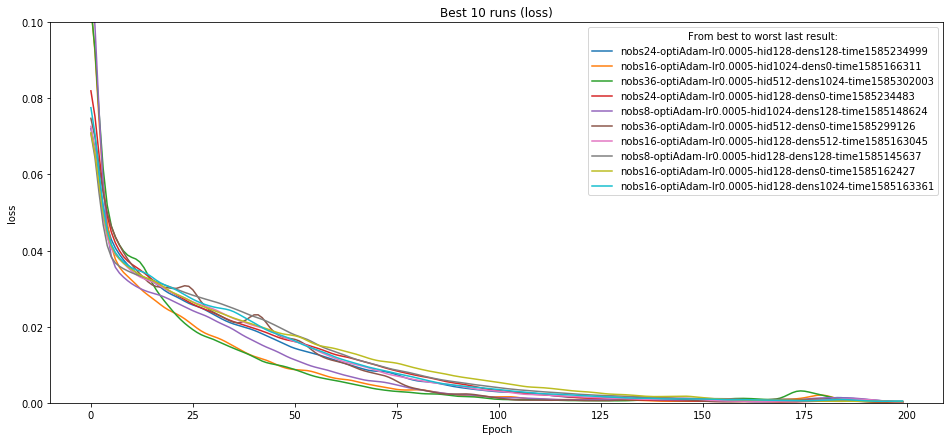

In [11]:
N = 10
metric= "loss"
showBestMetric(dfViz,metric,N)

Best N final validation loss train:

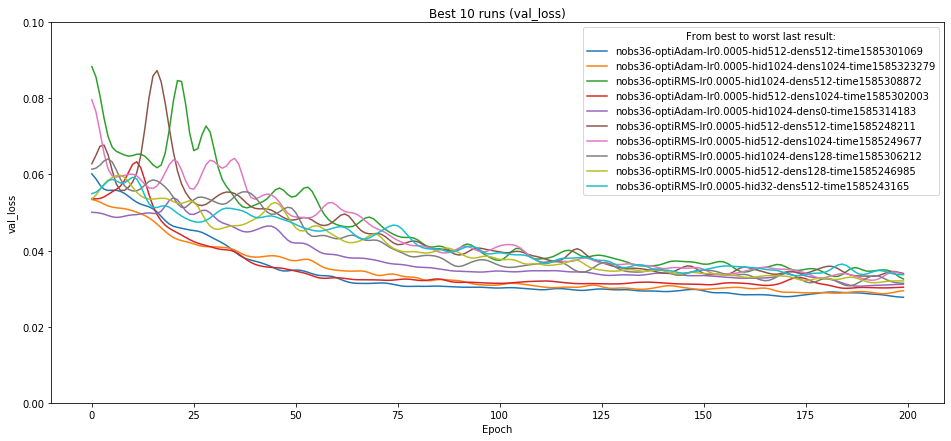

In [12]:
N = 10
metric= "val_loss"
showBestMetric(dfViz,metric,N)

## Stats

In [68]:
list_of_features = ["nobs","opti","hid","dens"]
N=10

print(f"===Mean of the last result for the {N} best last result of each feature, group by feature and ordered by mean best result===")
for metric in ["loss","val_loss"]:
    # for each metric
    print("\n----==== {} ====----".format(metric))
    for feature in list_of_features:
        # for each feature of the model
        print("--- {} --".format(feature))
        dico = {}
        for unique in dfViz[feature].unique():
            # for each unique value
            dico[unique] = dfViz[dfViz[feature] == unique][dfViz["Metric"] == metric].nsmallest(N, ['lastValue'])["lastValue"].mean()
        # print the result for this feature
        orderKey = sorted(dico, key=dico.get)
        for k in orderKey:
            print(k,": ",round(dico[k],5))
        

===Mean of the last result for the 10 best last result of each feature, group by feature and ordered by mean best result===

----==== loss ====----
--- nobs --
16 :  0.00046
8 :  0.00055
24 :  0.00072
36 :  0.00093
--- opti --
Adam :  0.00027
RMS :  0.00126
--- hid --
128 :  0.00042
512 :  0.0005
1024 :  0.00057
32 :  0.00596
--- dens --
0 :  0.00046
128 :  0.00066
1024 :  0.00073
512 :  0.00073

----==== val_loss ====----
--- nobs --
36 :  0.03099
24 :  0.04063
16 :  0.05571
8 :  0.05901
--- opti --
RMS :  0.03299
Adam :  0.03921
--- hid --
512 :  0.03397
1024 :  0.03448
32 :  0.0512
128 :  0.05506
--- dens --
512 :  0.03891
0 :  0.04029
1024 :  0.04067
128 :  0.04162


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
